### Problem Statement:

The objective of this project is to develop an intelligent system using deep learning to predict
the faults in manufacturing processes. By analyzing various manufacturing parameters and
process data, the system will predict the faulty tyre generated during production. This predictive
capability will enable manufacturers to proactively optimize their processes, reduce waste, and
improve overall production efficiency.

In [2]:
#Import relevant Libraries
import os
import torch
import warnings
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import MobileNet
%matplotlib inline

In [3]:
#Ignore Any Warnings
warnings.filterwarnings('ignore')

### Data Collection

In [4]:
#data directory path
data_dir="../data"

In [5]:
# Define the classes
classes=['defective','good']

In [6]:
# Create train and test directories and split images into these directories
for class_name in classes:
    train_dir=os.path.join(data_dir,'train',class_name)
    os.makedirs(train_dir,exist_ok=True)
    test_dir=os.path.join(data_dir,'test',class_name)
    os.makedirs(test_dir,exist_ok=True)
    images=os.listdir(os.path.join(data_dir,class_name))
    train_images,test_images=train_test_split(images,test_size=0.2,random_state=42)
    for img in train_images:
        source_path=os.path.join(data_dir,class_name,img)
        destination_path=os.path.join(train_dir)
        shutil.copy(source_path,destination_path)
    for img in test_images:
        source_path=os.path.join(data_dir,class_name,img)
        destination_path=os.path.join(test_dir)
        shutil.copy(source_path,destination_path)

### Data Preprocessing

In [7]:
# Create an ImageDataGenerator for data augmentation
generator=ImageDataGenerator(rescale=1.0/255.0,
      rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest')

In [7]:
# Create training and test data generators
train_generator=generator.flow_from_directory('../data/train',class_mode="binary",
                                            batch_size=64,target_size=(224,224))
test_generator=generator.flow_from_directory("../data/test",class_mode="binary",
                                           batch_size=64,target_size=(224,224))

Found 1484 images belonging to 2 classes.
Found 372 images belonging to 2 classes.


In [8]:
# Display sample images from the training set
images, labels = next(train_generator)

In [9]:
random_indices = np.random.choice(images.shape[0], 5, replace=False)

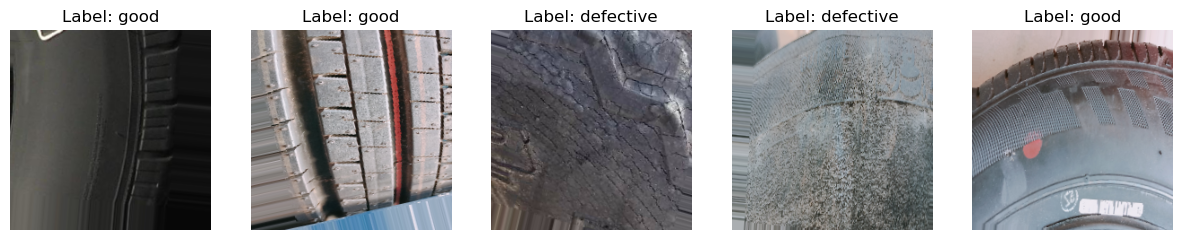

In [10]:
plt.figure(figsize=(15, 10))
for i, idx in enumerate(random_indices):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(images[idx])
    if labels[idx]==1:
         plt.title(f'Label: good')
    else:
         plt.title(f'Label: defective')
    plt.axis('off')
plt.show()

### Exploratory Data Analysis

In [11]:
# Function to create a bar plot of class distribution
def bar_plot(directory):
    classes=os.listdir(directory)
    class_counts={class_name:0 for class_name in classes}
    for class_name in classes:
        class_dir=os.path.join(directory,class_name)
        class_counts[class_name]=len(os.listdir(class_dir))
    plt.figure()
    plt.bar(class_counts.keys(),class_counts.values())
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Bar Plot of Classes in '+ directory)
    plt.savefig('../visuals/') 
    plt.show()

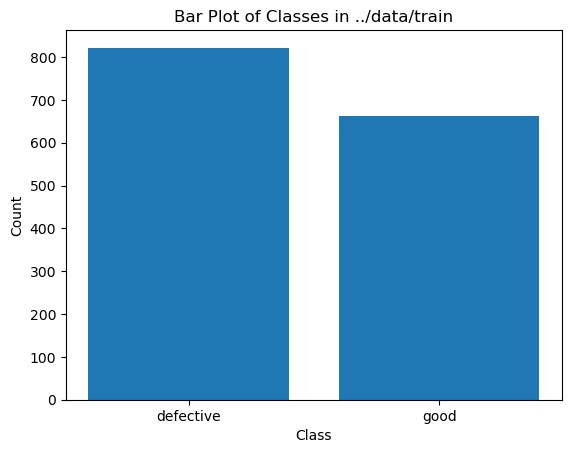

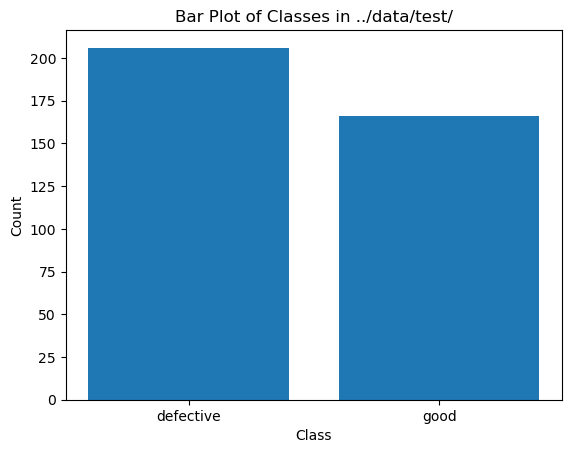

In [12]:
# Generate bar plots for train and test directories
train_dir='../data/train'
test_dir='../data/test/'
bar_plot(train_dir)
bar_plot(test_dir)

### Model Selection

In [44]:
#Define and Compile VGG16 Model
# Load the VGG16 model pre-trained on ImageNet, without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [45]:
# Add custom layers on top of VGG16
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

In [46]:
# Create final model
model = Model(inputs=base_model.input, outputs=predictions)

In [47]:
# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

### Hyperparameter Tuning

In [27]:
# hyper-parameters
batch_size = 32
epochs = 5

In [56]:
# Define early stopping callback.Early stopping is a technique used during training to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

### Model Training

In [57]:
# Train the model
history=model.fit(train_generator,validation_data=test_generator,epochs=epochs,batch_size=batch_size,verbose=2,callbacks=[early_stopping])

Epoch 1/5


2024-05-18 22:32:53.999721: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 4 of 8
2024-05-18 22:33:05.526505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


24/24 - 682s - 28s/step - accuracy: 0.5451 - loss: 0.6949 - val_accuracy: 0.5538 - val_loss: 0.6920
Epoch 2/5


2024-05-18 22:44:16.022643: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 4 of 8
2024-05-18 22:44:27.711121: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


24/24 - 767s - 32s/step - accuracy: 0.5539 - loss: 0.6912 - val_accuracy: 0.5538 - val_loss: 0.6905
Epoch 3/5


2024-05-18 22:57:01.919193: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 4 of 8
2024-05-18 22:57:14.597422: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


24/24 - 740s - 31s/step - accuracy: 0.5539 - loss: 0.6901 - val_accuracy: 0.5538 - val_loss: 0.6893
Epoch 4/5


2024-05-18 23:09:23.513004: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 4 of 8
2024-05-18 23:09:35.139333: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


24/24 - 751s - 31s/step - accuracy: 0.5539 - loss: 0.6889 - val_accuracy: 0.5538 - val_loss: 0.6885
Epoch 5/5


2024-05-18 23:21:54.823212: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 4 of 8
2024-05-18 23:22:06.350414: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


24/24 - 743s - 31s/step - accuracy: 0.5539 - loss: 0.6882 - val_accuracy: 0.5538 - val_loss: 0.6881


In [61]:
# Save the model
model.save('../models/vgg16.h5')

In [14]:
## Load the saved model
model = load_model('../models/vgg16.h5')

### Model Evaluation

In [18]:
# Evaluate the model on the test set
val_loss,val_accuracy=model.evaluate(test_generator)

6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.5629 - loss: 0.6868


### Model Selection

In [33]:
# Load the MobileNet model pre-trained on ImageNet, without the top layer
base_model = MobileNet(weights='imagenet', include_top=False,input_shape=(224, 224, 3))

In [34]:
# Add custom layers on top of VGG16
x = Flatten()(base_model.output)
x = Dense(64, activation='relu')(x)
x = Dense(24, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

In [35]:
# Create final model
model = Model(inputs=base_model.input, outputs=predictions)

In [36]:
# Compile the model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

### Model Training

In [37]:
# Train the model
history=model.fit(train_generator,epochs=epochs,validation_data=test_generator,batch_size=batch_size,verbose=1) 

Epoch 1/5


2024-05-19 15:24:49.176611: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:30: Filling up shuffle buffer (this may take a while): 4 of 8
2024-05-19 15:25:00.747163: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


24/24 ━━━━━━━━━━━━━━━━━━━━ 177s 6s/step - accuracy: 0.5929 - loss: 1.5001 - val_accuracy: 0.6828 - val_loss: 0.6020
Epoch 2/5


2024-05-19 15:27:40.103996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:30: Filling up shuffle buffer (this may take a while): 3 of 8
2024-05-19 15:27:53.187509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:30: Filling up shuffle buffer (this may take a while): 7 of 8
2024-05-19 15:27:57.010586: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


24/24 ━━━━━━━━━━━━━━━━━━━━ 184s 7s/step - accuracy: 0.7917 - loss: 0.3550 - val_accuracy: 0.5081 - val_loss: 0.7117
Epoch 3/5


2024-05-19 15:30:44.268808: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:30: Filling up shuffle buffer (this may take a while): 3 of 8
2024-05-19 15:30:54.302436: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:30: Filling up shuffle buffer (this may take a while): 6 of 8
2024-05-19 15:31:00.507083: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


24/24 ━━━━━━━━━━━━━━━━━━━━ 198s 7s/step - accuracy: 0.8046 - loss: 0.3577 - val_accuracy: 0.6263 - val_loss: 0.6870
Epoch 4/5


2024-05-19 15:34:02.009231: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:30: Filling up shuffle buffer (this may take a while): 3 of 8
2024-05-19 15:34:12.862162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:30: Filling up shuffle buffer (this may take a while): 7 of 8
2024-05-19 15:34:16.605923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


24/24 ━━━━━━━━━━━━━━━━━━━━ 200s 7s/step - accuracy: 0.8885 - loss: 0.2588 - val_accuracy: 0.7823 - val_loss: 0.6457
Epoch 5/5


2024-05-19 15:37:21.992888: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:30: Filling up shuffle buffer (this may take a while): 3 of 8
2024-05-19 15:37:38.848852: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


24/24 ━━━━━━━━━━━━━━━━━━━━ 192s 7s/step - accuracy: 0.8489 - loss: 0.3004 - val_accuracy: 0.8737 - val_loss: 0.3041


In [38]:
# Train the model again.
history=model.fit(train_generator,epochs=epochs,validation_data=test_generator,batch_size=batch_size,verbose=1) 

Epoch 1/5


2024-05-19 15:41:01.292532: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:49: Filling up shuffle buffer (this may take a while): 4 of 8
2024-05-19 15:41:13.319798: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


24/24 ━━━━━━━━━━━━━━━━━━━━ 194s 7s/step - accuracy: 0.8708 - loss: 0.2712 - val_accuracy: 0.8306 - val_loss: 1.1634
Epoch 2/5


2024-05-19 15:44:14.375118: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:49: Filling up shuffle buffer (this may take a while): 3 of 8
2024-05-19 15:44:25.124757: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:49: Filling up shuffle buffer (this may take a while): 6 of 8
2024-05-19 15:44:31.890262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


24/24 ━━━━━━━━━━━━━━━━━━━━ 212s 8s/step - accuracy: 0.8943 - loss: 0.2183 - val_accuracy: 0.9328 - val_loss: 0.1755
Epoch 3/5


2024-05-19 15:47:48.991007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:49: Filling up shuffle buffer (this may take a while): 3 of 8
2024-05-19 15:48:07.451919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


24/24 ━━━━━━━━━━━━━━━━━━━━ 205s 7s/step - accuracy: 0.9324 - loss: 0.1938 - val_accuracy: 0.8790 - val_loss: 0.2541
Epoch 4/5


2024-05-19 15:51:11.782027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:49: Filling up shuffle buffer (this may take a while): 3 of 8
2024-05-19 15:51:22.268096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:49: Filling up shuffle buffer (this may take a while): 6 of 8
2024-05-19 15:51:29.440572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


24/24 ━━━━━━━━━━━━━━━━━━━━ 202s 7s/step - accuracy: 0.8929 - loss: 0.2592 - val_accuracy: 0.8414 - val_loss: 0.3086
Epoch 5/5


2024-05-19 15:54:33.227325: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:49: Filling up shuffle buffer (this may take a while): 3 of 8
2024-05-19 15:54:43.672309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:49: Filling up shuffle buffer (this may take a while): 6 of 8
2024-05-19 15:54:49.961916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


24/24 ━━━━━━━━━━━━━━━━━━━━ 198s 7s/step - accuracy: 0.8369 - loss: 0.3226 - val_accuracy: 0.8737 - val_loss: 0.2878


### Model Evaluation

In [39]:
# Evaluate the model on the test set
model.evaluate(test_generator)

6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.8680 - loss: 0.2838


[0.3002111315727234, 0.8494623899459839]

In [50]:
# Save the model
model.save("../models/mobilenet.h5")

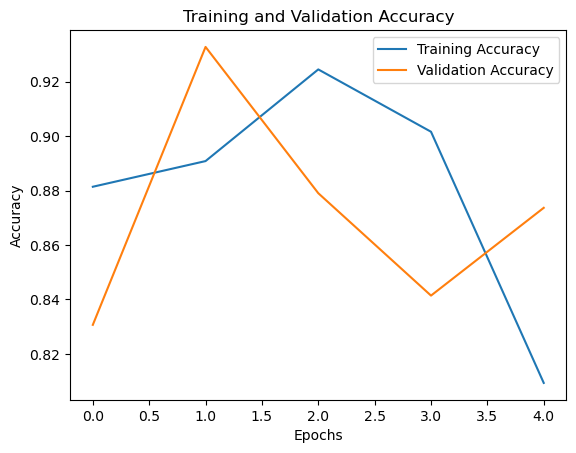

In [40]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [45]:
# Function to plot accuracies over epochs
def plot_accuracies(history):
    accuracies = history.history['val_accuracy']
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

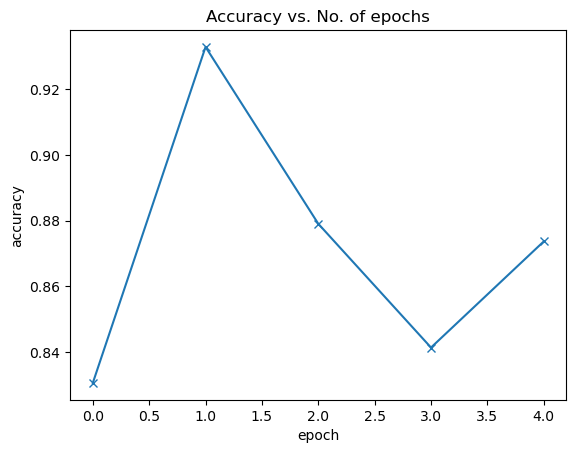

In [46]:
plot_accuracies(history)

In [52]:
# Display predictions on sample images from the test set
images, labels = next(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


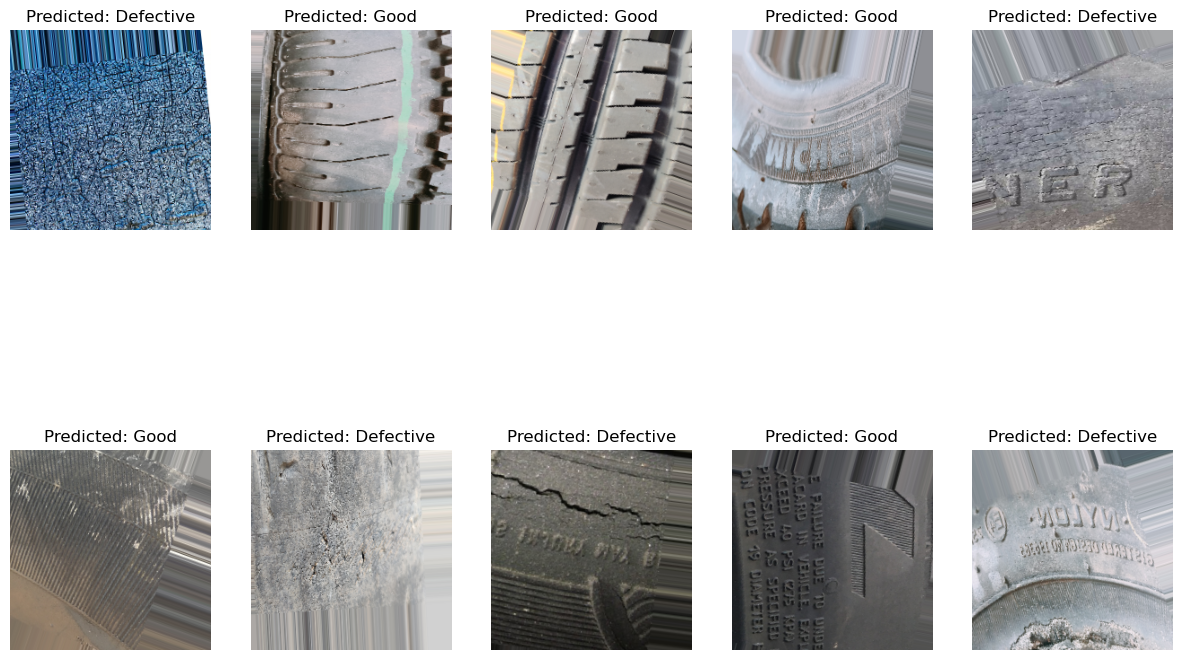

In [57]:
plt.figure(figsize=(15, 10))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)  # 2 rows and 5 columns
    img_array = images[i]
    prediction = model.predict(np.expand_dims(img_array, axis=0))
    if prediction[0] > 0.5:
        label = "Good"
    else:
        label = "Defective"
    plt.imshow(img_array)
    plt.title(f"Predicted: {label}")
    plt.axis('off')
plt.show()